### 锚框

锚框：它以每个像素为中心生成多个大小和宽高比不同的边界框。


假设输入图像高为h，宽为w。设缩放比例为s$\in$(0,1],且宽高比为r>0,那么锚框的宽和高将分别为ws$\sqrt{r}$和hs/$\sqrt{r}$

假设我们分别设定好一组缩放比例为$s_1,s2....s_n$和一组宽高比$r_1,r_2...r_m$,我们通常只对包含$s_1$和$r_1$的缩放比例和宽高比的组合感兴趣，即

$(s_1,r_1),(s_1,r_2),...(s_1,r_m),(s_2,r_1),(s_3,r_1),...,(s_n,r_1)$

以相同像素为中心的锚框的数量为n+m-1

In [1]:
%matplotlib inline
from PIL import Image
import numpy as np
import math
import torch
import utils

print(torch.__version__)

1.3.1


In [2]:
img=Image.open('catdog.jpg')
w,h=img.size
print("w=%d,h=%d"%(w,h))

w=472,h=356


In [3]:
#定义生成锚框的函数
def MultiBoxPrior(feature_map,sizes=[0.75,0.5,0.25],ratios=[1,2,0.5]):
    '''
        参数说明:
            feature_map:torch tensor,shape:[N,C,H,W]
            size:缩放比例
            ratio:宽高比
        返回值:
            anchors of shape (1,num_anchors,4).每个batch里每个都一样，所以第一维为1
    '''
    pairs=[] #pair of (size,sqrt(ratio))
    for r in ratios:
        pairs.append([sizes[0],math.sqrt(r)])
    for s in sizes[1:]:
        pairs.append([s,math.sqrt(ratios[0])])
    
    pairs=np.array(pairs)
    
    ss1=pairs[:,0]*pairs[:,1] #size*sqrt(ratio)
    ss2=pairs[:,0]/pairs[:,1] #size/sqrt(ratio)
    
    base_anchors=np.stack([-ss1,-ss2,ss1,ss2],axis=1)/2
    
    h,w=feature_map.shape[-2:]
    shifts_x=np.arange(0,w)/w
    shifts_y=np.arange(0,h)/h
    shift_x,shift_y=np.meshgrid(shifts_x,shifts_y)
    shift_x=shift_x.reshape(-1)
    shift_y=shift_y.reshape(-1)
    shifts=np.stack((shift_x,shift_y,shift_x,shift_y),axis=1)
    
    anchors=shifts.reshape((-1,1,4))+base_anchors.reshape((1,-1,4))
    
    return torch.tensor(anchors,dtype=torch.float32).view(1,-1,4)

In [4]:
X=torch.Tensor(1,3,h,w) #构造输入数据
Y=MultiBoxPrior(X)
Y.shape

torch.Size([1, 840160, 4])

In [5]:
boxes=Y.reshape((h,w,5,4))
#这里是归一化到[0,1]的结果
boxes[250,250,0,:] #获取以(250,250)为中心的第一个锚框

tensor([0.1547, 0.3272, 0.9047, 1.0772])

In [6]:
#定义描绘以某个像素为中心的所有锚框
def show_bboxes(axes,bboxes,labels=None,colors=None):
    def _mask_list(obj,default_values=None):
        if obj is None:
            obj=default_values
        elif not isinstance(obj,(list,tuple)):
            obj=[obj]
        return obj
    
    labels=_mask_list(labels)
    colors=_mask_list(colors,['b','g','r','m','c'])
    for i,bbox in enumerate(bboxes):
        color=colors[i%len(colors)]
        rect=utils.bbox_to_rect(bbox.detach().cpu().numpy(),color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=6, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

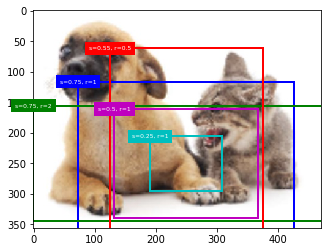

In [7]:
fig=utils.plt.imshow(img)
bbox_scale=torch.tensor([[w,h,w,h]],dtype=torch.float32)
show_bboxes(fig.axes,boxes[250,250,:,:]*bbox_scale,
            ['s=0.75, r=1', 's=0.75, r=2', 's=0.55, r=0.5', 's=0.5, r=1', 's=0.25, r=1'])

### 交并比

Jaccard系数可以衡量两个集合的相识度。给定集合A和B。它们的Jaccard系数即两者交集大小除以两者并集大小:

$J(A,B)=\frac{|A\bigcap B|}{|A\bigcup B|}$

当衡量两个边界框的相识度时，我们通常将Jaccard系数称为交并比，即两个边界框相交面积与相并面积之比。交并比的取值范围在0和1之间。
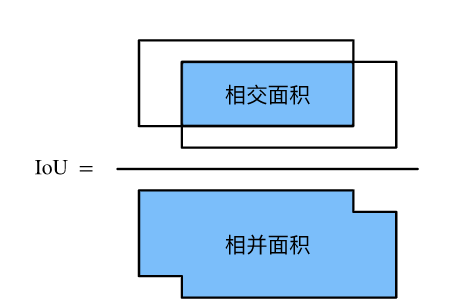

### 标注训练集的锚框

为了训练目标检测模型，我们需要为每个锚框标注两类标签:一是锚框所含目标的类别，简称类别；二是真实边界框相对锚框的偏移量，简称偏移量(offset).

**在目标检测时，我们首先生成多个锚框，然后为每个锚框预测类别以及偏移量，接着根据预测的偏移量调整锚框位置从而得到预测边界框，最后筛选需要输出的预测边界框**

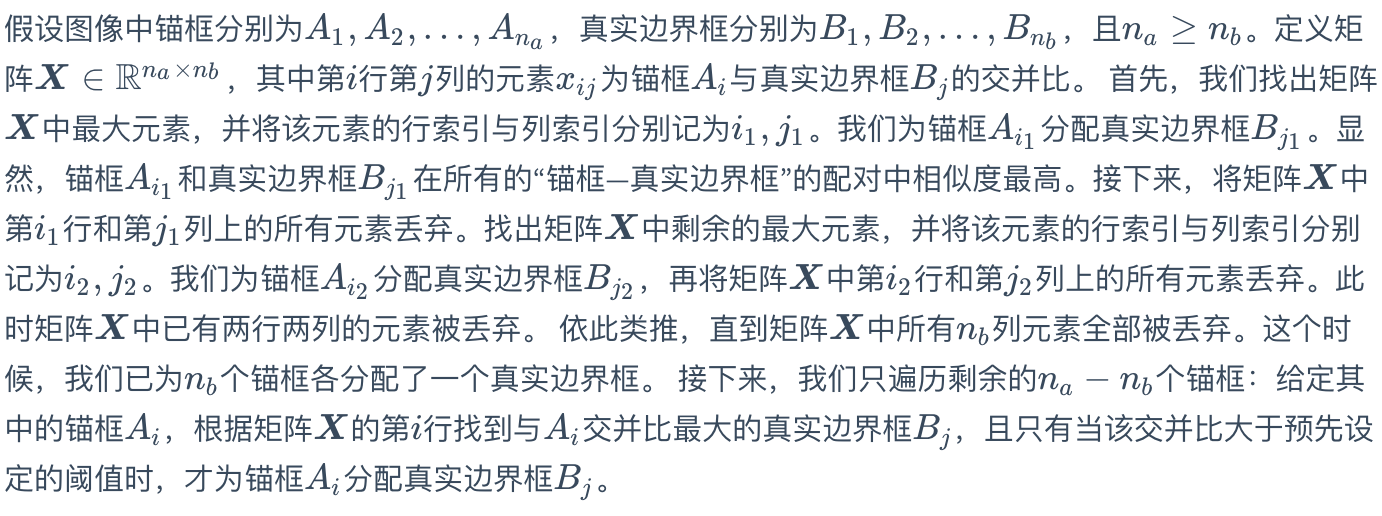

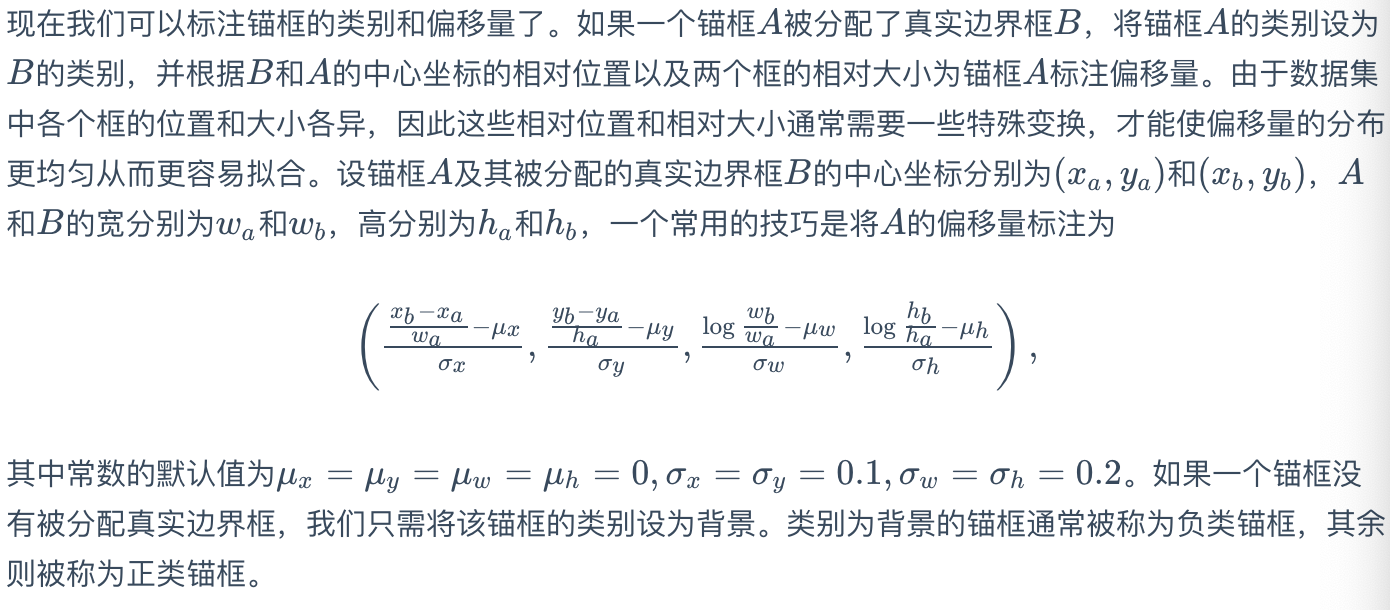

总结:
假设图像锚框分别为$A_1,A_2,...A_{n_a}$，真实边界框分别为$B_1,B_2,...B_{n_b}$，且$n_a >= n_b$，定义矩阵X,$X_{ij}$定义为锚框$A_i$与$B_j$的交并比

1. 首先找出前$n_b$个交并比大的锚框对应的真实边界框，对于剩下的$n_a-n_b$个锚框，我们只找出交并比大于阈值的锚框
2. 上述锚框的类别设为对应真实边界框的类别，偏移量计算参照上图
3. 未被分配真实边界框的锚框，我们将其类别设为背景，类别为背景的锚框通常称为负类锚框，其余称为正类锚框。

下面实现MultiBoxTarget函数来为锚框标注类别和偏移量。该函数将背景类别设为0，并令从零开始的目标类别的整数索引自加1.

In [8]:
def assign_anchor(bb,anchor,jaccard_threshold=0.5):
    '''
    为每个anchor分配真实的bb,anchor表示成归一化(xmin,ymin,xmax,ymax)
        参数:
            bb:真实边界框(bounding box),shape:(nb,4)
            anchor:待分配的anchor,shape:(na,4)
            jaccard_threshold:预先设定的阈值
        返回值:
            assigned_idx:shape:(na,)，每个anchor分配的真实bb对应的索引，若未分配任何bb则为-1
    '''
    na=anchor.shape[0]
    nb=bb.shape[0]
    jaccard=compute_jaccard(anchor,bb).detach().cpu().numpy()
    assigned_idx=np.ones(na)*-1 #初始化全为-1
    
    #先为每个bb分配一个anchor(不要求满足jaccard_threshold)
    jaccard_cp=jaccard.copy()
    for j in range(nb):
        i=np.argmax(jaccard_cp[:,j])
        assigned_idx[i]=j
        jaccard_cp[i,:]=float("-inf") #赋值为负无穷，相当于去掉这一行
        
    #处理还未被分配的anchor,要求满足jaccard_threshold
    for i in range(na):
        if assigned_idx[i]==-1:
            j=np.argmax(jaccard[i,:])
            if jaccard[i,j]>=jaccard_threshold:
                assigned_idx[i]=j
    
    return torch.tensor(assigned_idx,dtype=torch.long)

def xy_to_cxcy(xy):
    '''
    将(xmin,ymin,xmax,ymax)形式的anchor转换成(center_x,center_y,w,h)形式的
    Args:
        xy:shape(n_boxes,4)
    Returns:
        shape(n_boxes,4)
    '''
    return torch.cat([(xy[:,2:]+xy[:,:2])/2,xy[:,2:]-xy[:,:2]],1)


def MultiBoxTarget(anchor,label):
    '''
    Args:
        anchor:输入的锚框，shape(1,锚框总数，4)
        label:真实标签，hsape(batch_num,每张图片最多的真实锚框数,5)
            第二维中，如果给定图片没有这么多锚框，可以先用-1填充空白
            最后一维中的元素为[类别标签，4个坐标值]
            
    Returns:
        列表,[bbox_offset,bbox_mask,cls_labels]
        bbox_offset:每个锚框的标注偏移量，形状为(batch_num,锚框总数*4)
        bbox_mask:形状同bbox_offset,每个锚框的掩码--对应上面的偏移量
                    负类锚框对应的掩码为0，正类锚框的掩码为1
        cls_labels:每个锚框的标注类别，其中0表示为背景，形状为(bn,锚框总数)
    '''
    assert len(anchor.shape)==3 and len(label.shape)==3
    #bn为batch_num
    bn=label.shape[0]
    
    def MultiBoxTarget_one(anc,lab,eps=1e-6):
        '''
        处理batch中的一个
        Args:
            anc:shape(锚框总数,4)
            lab:shape(真实锚框数,5) 5代表[类别标签，四个坐标值]
            eps:一个极小值，防止log0
        Returns:
            offset:shape(锚框总数*4,)
            bbox_mask:(锚框总数*4,)0代表背景，1代表非背景
            cls_labels:(锚框总数,1),0代表背景
        '''
        an=anc.shape[0]
        #找到匹配的真实边界框
        assigned_idx=assign_anchor(lab[:,1:],anc)
        bbox_mask=((assigned_idx>=0)).float().unsqueeze(-1).repeat(1,4) #（锚框总数,4
        
        cls_labels=torch.zeros(an,dtype=torch.long) #0表示背景
        assigned_bb=torch.zeros((an,4),dtype=torch.float32) #所有anchor对应的bb坐标
        for i in range(an):
            bb_idx=assigned_idx[i]
            if bb_idx>=0:#即非背景
                cls_labels[i]=lab[bb_idx,0].long().item()+1#注意要加一
                assigned_bb[i,:]=lab[bb_idx,1:]
        
        center_anc=xy_to_cxcy(anc) #(center_x,center_y,w,h)
        center_assigned_bb=xy_to_cxcy(assigned_bb)
        
        offset_xy=10.0*(center_assigned_bb[:,:2]-center_anc[:,:2])/center_anc[:,2:]
        offset_wh=5.0*torch.log(eps+center_assigned_bb[:,2:]/center_anc[:,2:])
        offset=torch.cat([offset_xy,offset_wh],dim=1)*bbox_mask #(锚框总数，4)
        
        return offset.view(-1),bbox_mask.view(-1),cls_labels
    
    batch_offset=[]
    batch_mask=[]
    batch_cls_labels=[]
    for b in range(bn):
        offset,bbox_mask,cls_labels=MultiBoxTarget_one(anchor[0,:,:],label[b,:,:])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_labels)
    
    bbox_offset=torch.stack(batch_offset)
    bbox_mask=torch.stack(batch_mask)
    cls_labels=torch.stack(batch_cls_labels)
    
    return [bbox_offset,bbox_mask,cls_labels]


        

### 输出预测边界框

当锚框数量较多时，同一个目标上可能会输出较多相识的预测边界框，我们可以使用非极大值抑制算法（NMS）来移除相似的预测边界框。

非极大值抑制算法的工作原理如下:
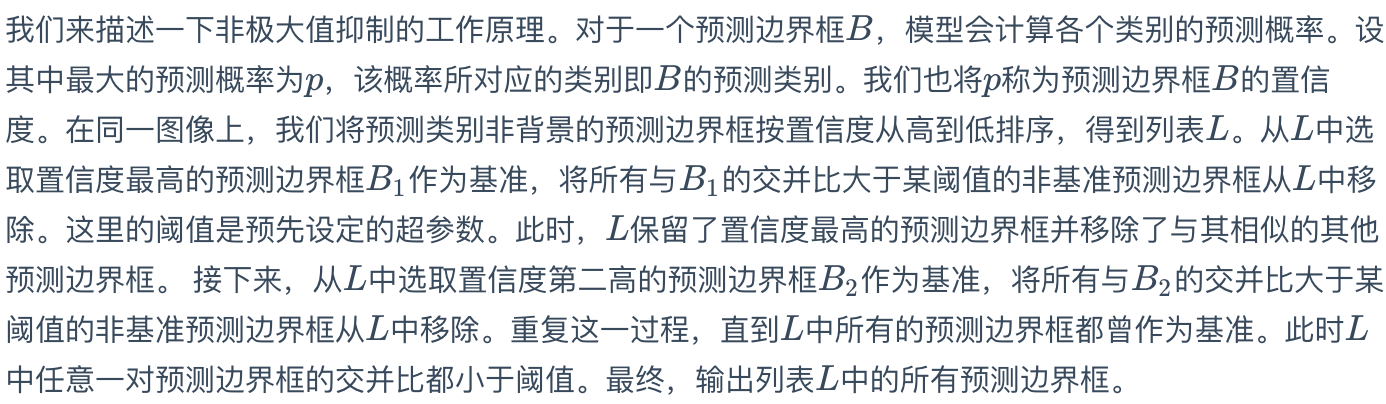

### 总结

1. 在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。
2. 预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。